# NBA OVER/UNDER BETTING PREDICTION MODEL #
## Complete Project: Data Loading → Classification Models → Betting Odds ##

# Install required packages #

In [1]:
%pip install xgboost scikit-learn pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


## Load and prepare data ##

In [2]:
# Load datasets
games_df = pd.read_csv('Games.csv')
player_statistics_df = pd.read_csv('PlayerStatistics.csv')
team_statistics_df = pd.read_csv('TeamStatistics.csv')

print(f"✅ Games loaded: {len(games_df):,} records")
print(f"✅ Player stats loaded: {len(player_statistics_df):,} records")
print(f"✅ Team stats loaded: {len(team_statistics_df):,} records")

✅ Games loaded: 72,278 records
✅ Player stats loaded: 1,638,575 records
✅ Team stats loaded: 144,556 records


## Filter for 2024-25 Season ##

In [3]:
season_mask = (player_statistics_df['gameDateTimeEst'] >= '2024-10-22')
season_stats_df = player_statistics_df[season_mask]

# Clean data
season_stats_df = season_stats_df[season_stats_df['numMinutes'].notna()]
season_stats_df = season_stats_df.drop(columns=['gameLabel', 'gameSubLabel', 'seriesGameNumber'], errors='ignore')

print(f"✅ Filtered to {len(season_stats_df):,} player-game records from 2024-25 season")

✅ Filtered to 37,336 player-game records from 2024-25 season


## Filter top 7 players by minutes per team ##

In [4]:
# Calculate total minutes by player
top_players = (
    season_stats_df.groupby(['playerteamName', 'firstName', 'lastName'])['numMinutes']
    .sum()
    .reset_index()
    .sort_values(['playerteamName', 'numMinutes'], ascending=[True, False])
    .groupby('playerteamName')
    .head(7)
)

# Create set for filtering
top_players_set = set(zip(top_players['playerteamName'], top_players['firstName'], top_players['lastName']))

# Filter to only top players
filtered_stats = season_stats_df[
    season_stats_df.apply(
        lambda row: (row['playerteamName'], row['firstName'], row['lastName']) in top_players_set,
        axis=1
    )
]

print(f"✅ Selected top 7 players from each team: {len(filtered_stats):,} records")

✅ Selected top 7 players from each team: 18,568 records


## Filter playoff teams ##

In [5]:
playoff_teams = [
    "Cavaliers", "Celtics", "Knicks", "Pacers", "Bucks", "Pistons", "Magic", "Heat",
    "Thunder", "Rockets", "Lakers", "Nuggets", "Clippers", "Timberwolves", "Warriors", "Grizzlies"
]

playoff_stats_df = filtered_stats[filtered_stats['playerteamName'].isin(playoff_teams)]

print(f"✅ Filtered to {len(playoff_teams)} playoff teams: {len(playoff_stats_df):,} records")

✅ Filtered to 16 playoff teams: 10,719 records


## Merge with game data ##

In [6]:
# Select relevant game columns
games_cols = ['gameId', 'gameDateTimeEst', 'hometeamName', 'awayteamName', 'homeScore', 'awayScore', 'winner', 'gameType', 'attendance']

# Merge
merged_df = pd.merge(
    playoff_stats_df,
    games_df[games_cols],
    on='gameId',
    how='left'
)

# Keep relevant columns
columns_to_keep = [
    'firstName', 'lastName', 'personId', 'gameId', 'gameDateTimeEst_x', 'playerteamName',
    'opponentteamName', 'hometeamName', 'awayteamName', 'gameType_x', 'attendance',
    'numMinutes', 'points', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted',
    'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
    'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage',
    'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal', 'foulsPersonal', 'turnovers',
    'plusMinusPoints', 'homeScore', 'awayScore'
]

merged_df_clean = merged_df[columns_to_keep].rename(
    columns={
        'gameDateTimeEste_x': 'gameDateTimeEst',
        'gameType_x': 'gameType'
    }
)

print(f"✅ Merged dataset created: {len(merged_df_clean):,} records")

✅ Merged dataset created: 10,719 records


## Merge with team statistics ##

In [7]:
# Merge player's team stats
merged_with_team = pd.merge(
    merged_df_clean,
    team_statistics_df.add_prefix('team_'),
    left_on=['gameId', 'playerteamName'],
    right_on=['team_gameId', 'team_teamName'],
    how='left'
)

# Merge opponent team stats
merged_with_team = pd.merge(
    merged_with_team,
    team_statistics_df.add_prefix('opp_'),
    left_on=['gameId', 'opponentteamName'],
    right_on=['opp_gameId', 'opp_teamName'],
    how='left'
)

print("\nAvailable columns after merge:")
print([col for col in merged_with_team.columns if not col.startswith('team_') and not col.startswith('opp_')])

# Final column selection
final_columns = [
    # Player/game context
    'firstName', 'lastName', 'personId', 'gameId', 'gameDateTimeEst', 'playerteamName', 'opponentteamName',
    'hometeamName', 'awayteamName', 'gameType',
    # Player stats
    'numMinutes', 'points', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade', 'threePointersPercentage',
    'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage', 'reboundsDefensive',
    'reboundsOffensive', 'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
    # Game outcome
    'homeScore', 'awayScore',
    # Team stats
    'team_teamScore', 'team_assists', 'team_blocks', 'team_steals', 'team_fieldGoalsPercentage',
    'team_threePointersPercentage', 'team_freeThrowsPercentage', 'team_reboundsTotal', 'team_turnovers', 'team_plusMinusPoints',
    # Opponent stats
    'opp_teamScore', 'opp_assists', 'opp_blocks', 'opp_steals', 'opp_fieldGoalsPercentage',
    'opp_threePointersPercentage', 'opp_freeThrowsPercentage', 'opp_reboundsTotal', 'opp_turnovers', 'opp_plusMinusPoints'
]

# Add gameDateTimeEst if it exists
if 'gameDateTimeEst' in merged_with_team.columns:
    final_columns.insert(4, 'gameDateTimeEst')
elif 'gameDateTimeEst_x' in merged_with_team.columns:
    merged_with_team['gameDateTimeEst'] = merged_with_team['gameDateTimeEst_x']
    final_columns.insert(4, 'gameDateTimeEst')

# Filter to only existing columns
final_columns = [col for col in final_columns if col in merged_with_team.columns]

final_df = merged_with_team[final_columns]

print(f"✅ Final dataset ready: {len(final_df):,} records with {len(final_columns)} features")
print(f"✅ Teams included: {final_df['playerteamName'].nunique()}")
print(f"✅ Players included: {final_df['personId'].nunique()}")


Available columns after merge:
['firstName', 'lastName', 'personId', 'gameId', 'gameDateTimeEst_x', 'playerteamName', 'opponentteamName', 'hometeamName', 'awayteamName', 'gameType', 'attendance', 'numMinutes', 'points', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade', 'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive', 'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints', 'homeScore', 'awayScore']
✅ Final dataset ready: 10,719 records with 53 features
✅ Teams included: 16
✅ Players included: 112


## Create Over/Under targets ##

In [8]:
def create_over_under_targets(df):
    """
    Create binary Over/Under targets based on player season averages
    """
    df = df.copy()
    
    # Calculate each player's season average
    player_avg_points = df.groupby('personId')['points'].transform('mean')
    player_avg_rebounds = df.groupby('personId')['reboundsTotal'].transform('mean')
    player_avg_assists = df.groupby('personId')['assists'].transform('mean')
    
    # Binary targets: 1 = Over, 0 = Under
    df['over_under_points'] = (df['points'] > player_avg_points).astype(int)
    df['over_under_rebounds'] = (df['reboundsTotal'] > player_avg_rebounds).astype(int)
    df['over_under_assists'] = (df['assists'] > player_avg_assists).astype(int)
    
    # Store averages for reference
    df['player_avg_points'] = player_avg_points
    df['player_avg_rebounds'] = player_avg_rebounds
    df['player_avg_assists'] = player_avg_assists
    
    return df

final_df_ou = create_over_under_targets(final_df)

print(f"✅ Over/Under targets created!")
print(f"\nDistribution:")
print(f"   Points - Over: {final_df_ou['over_under_points'].sum():,} | Under: {(~final_df_ou['over_under_points'].astype(bool)).sum():,}")
print(f"   Rebounds - Over: {final_df_ou['over_under_rebounds'].sum():,} | Under: {(~final_df_ou['over_under_rebounds'].astype(bool)).sum():,}")
print(f"   Assists - Over: {final_df_ou['over_under_assists'].sum():,} | Under: {(~final_df_ou['over_under_assists'].astype(bool)).sum():,}")

✅ Over/Under targets created!

Distribution:
   Points - Over: 5,050 | Under: 5,669
   Rebounds - Over: 4,801 | Under: 5,918
   Assists - Over: 4,798 | Under: 5,921


## Prepare features for modeling ##

In [9]:
feature_cols = [
    'numMinutes', 'fieldGoalsAttempted', 'threePointersAttempted', 'freeThrowsAttempted',
    'turnovers', 'plusMinusPoints', 
    'team_teamScore', 'team_assists', 'team_reboundsTotal', 
    'opp_teamScore', 'opp_reboundsTotal', 'opp_assists'
]

X = final_df_ou[feature_cols].fillna(0)

print(f"✅ Feature matrix ready: {X.shape[0]:,} samples × {X.shape[1]} features")

✅ Feature matrix ready: 10,719 samples × 12 features


## Train classification models ##

In [10]:
def train_betting_models(X, y, target_name):
    """
    Train Logistic Regression and XGBoost for betting predictions
    """
    # Split data (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    # ========== LOGISTIC REGRESSION ==========
    print(f"\n{'='*60}")
    print(f"Training Logistic Regression for {target_name}...")
    print(f"{'='*60}")
    
    lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    lr_metrics = {
        'accuracy': accuracy_score(y_test, lr_pred),
        'precision': precision_score(y_test, lr_pred, zero_division=0),
        'recall': recall_score(y_test, lr_pred, zero_division=0),
        'f1': f1_score(y_test, lr_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, lr_pred_proba)
    }
    
    print(f"\n📊 Logistic Regression Performance:")
    print(f"   Accuracy:  {lr_metrics['accuracy']:.4f}")
    print(f"   Precision: {lr_metrics['precision']:.4f}")
    print(f"   Recall:    {lr_metrics['recall']:.4f}")
    print(f"   F1-Score:  {lr_metrics['f1']:.4f}")
    print(f"   ROC-AUC:   {lr_metrics['roc_auc']:.4f}")
    
    results['Logistic Regression'] = {
        'model': lr_model,
        'predictions': lr_pred,
        'probabilities': lr_pred_proba,
        'metrics': lr_metrics,
        'confusion_matrix': confusion_matrix(y_test, lr_pred)
    }
    
    # ========== XGBOOST ==========
    print(f"\n{'='*60}")
    print(f"Training XGBoost for {target_name}...")
    print(f"{'='*60}")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    xgb_metrics = {
        'accuracy': accuracy_score(y_test, xgb_pred),
        'precision': precision_score(y_test, xgb_pred, zero_division=0),
        'recall': recall_score(y_test, xgb_pred, zero_division=0),
        'f1': f1_score(y_test, xgb_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, xgb_pred_proba)
    }
    
    print(f"\n📊 XGBoost Performance:")
    print(f"   Accuracy:  {xgb_metrics['accuracy']:.4f}")
    print(f"   Precision: {xgb_metrics['precision']:.4f}")
    print(f"   Recall:    {xgb_metrics['recall']:.4f}")
    print(f"   F1-Score:  {xgb_metrics['f1']:.4f}")
    print(f"   ROC-AUC:   {xgb_metrics['roc_auc']:.4f}")
    
    results['XGBoost'] = {
        'model': xgb_model,
        'predictions': xgb_pred,
        'probabilities': xgb_pred_proba,
        'metrics': xgb_metrics,
        'confusion_matrix': confusion_matrix(y_test, xgb_pred)
    }
    
    # Calculate betting odds
    print(f"\n{'='*60}")
    print(f"BETTING ODDS ANALYSIS")
    print(f"{'='*60}")
    
    for model_name in ['Logistic Regression', 'XGBoost']:
        proba = results[model_name]['probabilities']
        avg_over_prob = proba.mean()
        avg_under_prob = 1 - avg_over_prob
        
        # Convert to American odds
        if avg_over_prob >= 0.5:
            over_odds = -100 * (avg_over_prob / (1 - avg_over_prob))
        else:
            over_odds = 100 * ((1 - avg_over_prob) / avg_over_prob)
        
        if avg_under_prob >= 0.5:
            under_odds = -100 * (avg_under_prob / (1 - avg_under_prob))
        else:
            under_odds = 100 * ((1 - avg_under_prob) / avg_under_prob)
        
        results[model_name]['over_probability'] = avg_over_prob
        results[model_name]['under_probability'] = avg_under_prob
        results[model_name]['over_odds'] = over_odds
        results[model_name]['under_odds'] = under_odds
        
        print(f"\n{model_name}:")
        print(f"   Over Probability: {avg_over_prob*100:.2f}%")
        print(f"   Under Probability: {avg_under_prob*100:.2f}%")
        print(f"   Over Odds (American): {over_odds:+.0f}")
        print(f"   Under Odds (American): {under_odds:+.0f}")
    
    # Determine winner
    winner = 'Logistic Regression' if lr_metrics['roc_auc'] > xgb_metrics['roc_auc'] else 'XGBoost'
    print(f"\n🏆 BEST MODEL FOR BETTING: {winner}")
    print(f"   (Based on ROC-AUC score - most important for betting)")
    
    return results, X_test, y_test, scaler

## Train models for all targets ##

In [11]:
# Train for Points
y_points = final_df_ou['over_under_points']
results_points, X_test_points, y_test_points, scaler_points = train_betting_models(X, y_points, "POINTS")

# Train for Rebounds
y_rebounds = final_df_ou['over_under_rebounds']
results_rebounds, X_test_rebounds, y_test_rebounds, scaler_rebounds = train_betting_models(X, y_rebounds, "REBOUNDS")

# Train for Assists
y_assists = final_df_ou['over_under_assists']
results_assists, X_test_assists, y_test_assists, scaler_assists = train_betting_models(X, y_assists, "ASSISTS")


Training Logistic Regression for POINTS...

📊 Logistic Regression Performance:
   Accuracy:  0.6908
   Precision: 0.6884
   Recall:    0.6277
   F1-Score:  0.6567
   ROC-AUC:   0.7662

Training XGBoost for POINTS...

📊 XGBoost Performance:
   Accuracy:  0.6782
   Precision: 0.6547
   Recall:    0.6703
   F1-Score:  0.6624
   ROC-AUC:   0.7574

BETTING ODDS ANALYSIS

Logistic Regression:
   Over Probability: 47.44%
   Under Probability: 52.56%
   Over Odds (American): +111
   Under Odds (American): -111

XGBoost:
   Over Probability: 47.30%
   Under Probability: 52.70%
   Over Odds (American): +111
   Under Odds (American): -111

🏆 BEST MODEL FOR BETTING: Logistic Regression
   (Based on ROC-AUC score - most important for betting)

Training Logistic Regression for REBOUNDS...

📊 Logistic Regression Performance:
   Accuracy:  0.6665
   Precision: 0.6423
   Recall:    0.5760
   F1-Score:  0.6074
   ROC-AUC:   0.7271

Training XGBoost for REBOUNDS...

📊 XGBoost Performance:
   Accuracy:  

## Comprehensive visualization ##

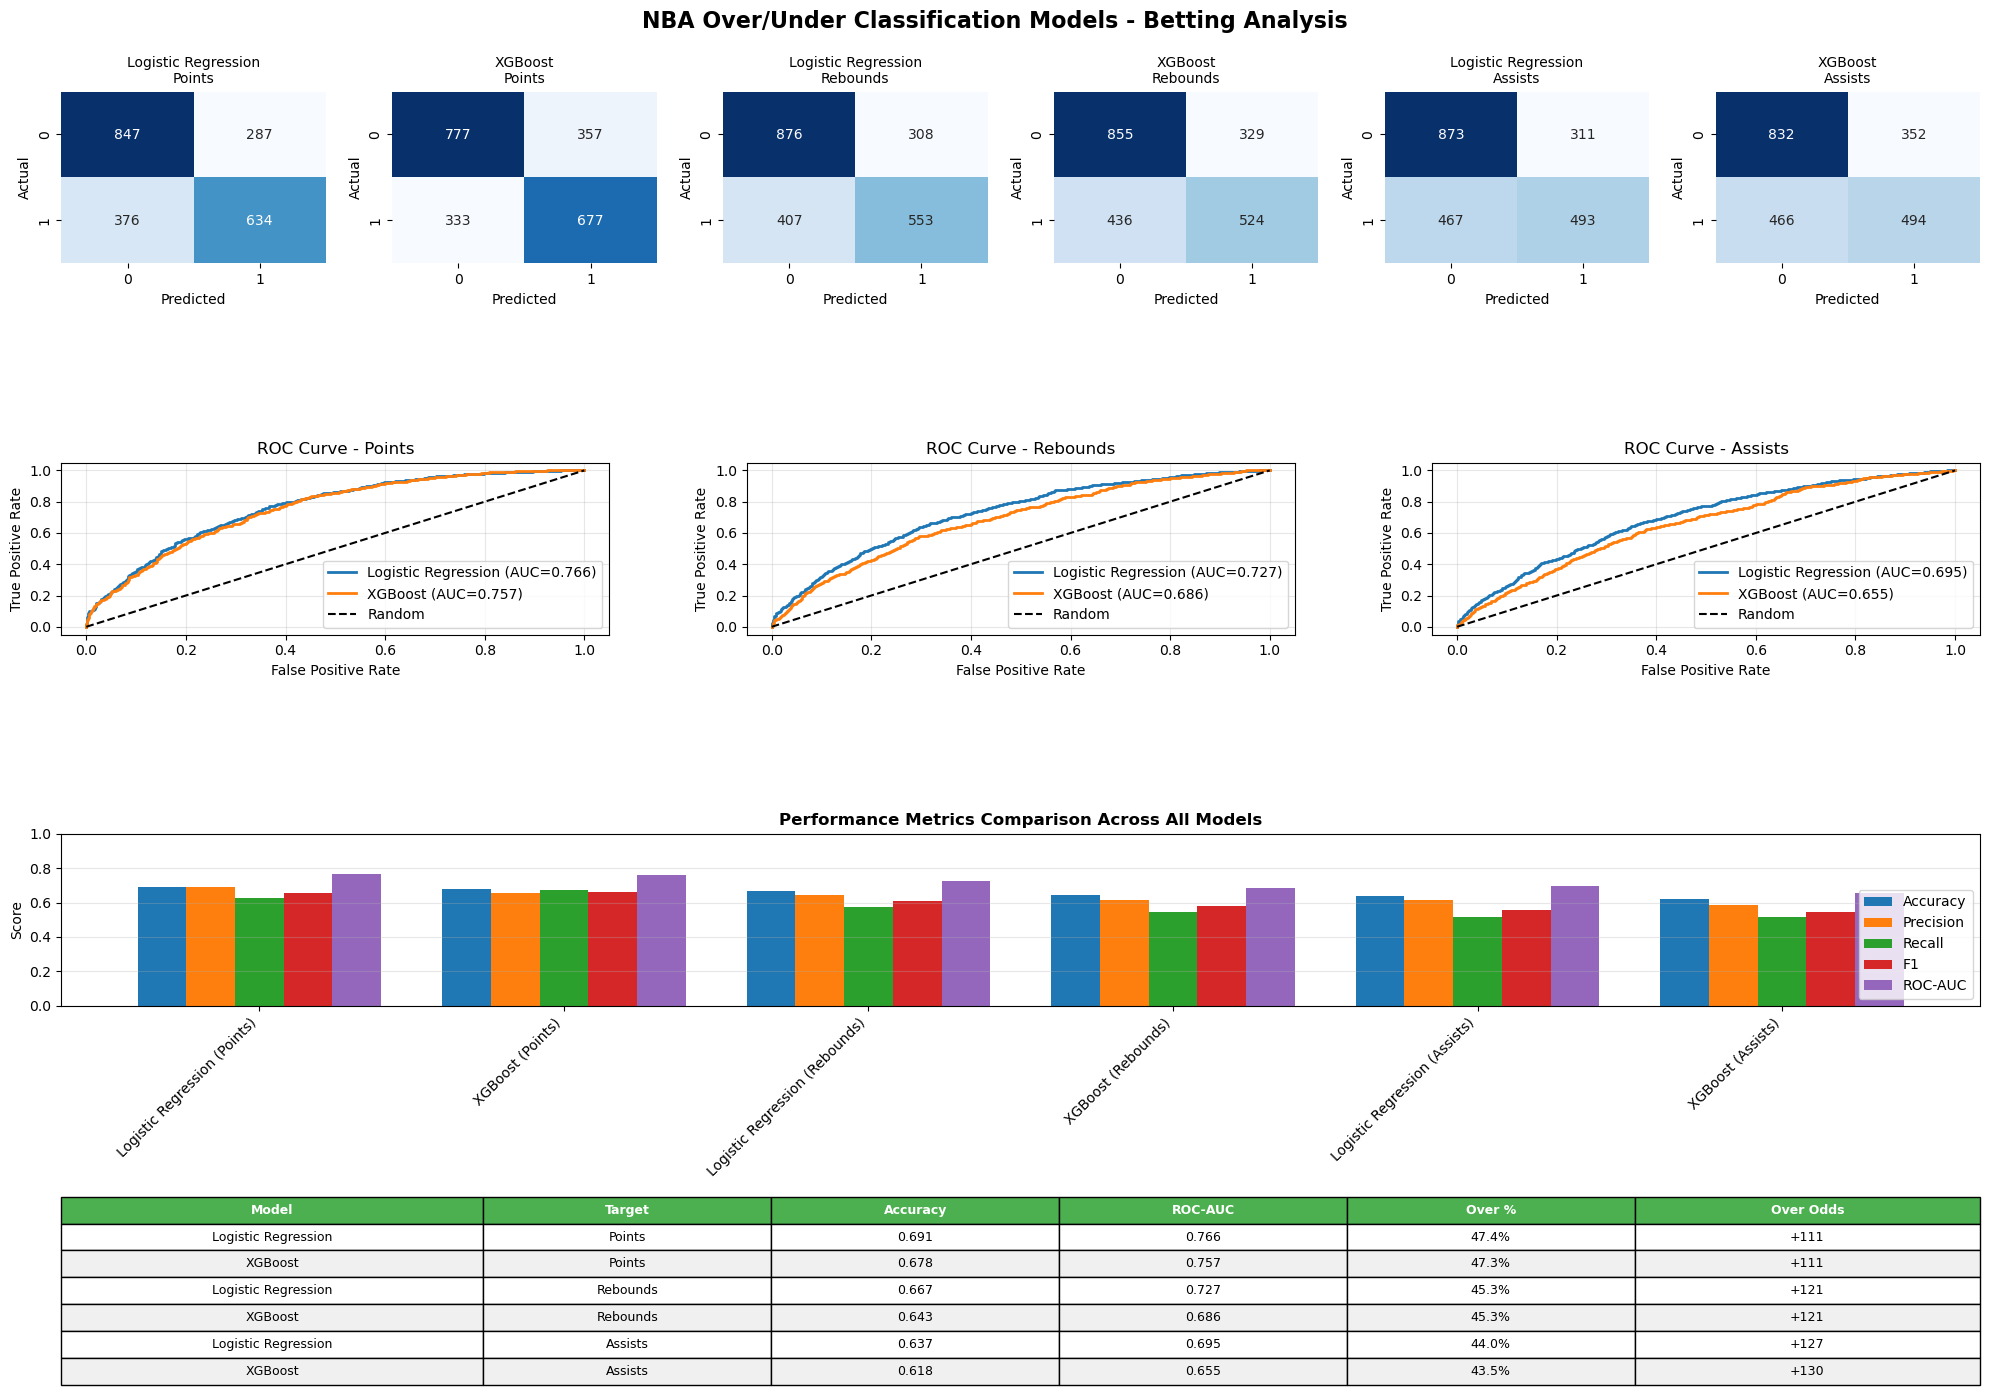

In [12]:
def plot_comprehensive_results(results_points, results_rebounds, results_assists,
                               y_test_points, y_test_rebounds, y_test_assists):
    """
    Create comprehensive visualization of all results
    """
    fig = plt.figure(figsize=(20, 14))
    
    targets = ['Points', 'Rebounds', 'Assists']
    all_results = [results_points, results_rebounds, results_assists]
    all_y_test = [y_test_points, y_test_rebounds, y_test_assists]
    
    # 1. CONFUSION MATRICES (Top Row)
    for idx, (target, results, y_test) in enumerate(zip(targets, all_results, all_y_test)):
        for model_idx, model_name in enumerate(['Logistic Regression', 'XGBoost']):
            ax = plt.subplot(4, 6, idx * 2 + model_idx + 1)
            cm = results[model_name]['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f'{model_name}\n{target}', fontsize=10)
            ax.set_ylabel('Actual')
            ax.set_xlabel('Predicted')
    
    # 2. ROC CURVES (Second Row)
    for idx, (target, results, y_test) in enumerate(zip(targets, all_results, all_y_test)):
        ax = plt.subplot(4, 3, 3 + idx + 1)
        
        for model_name in ['Logistic Regression', 'XGBoost']:
            proba = results[model_name]['probabilities']
            fpr, tpr, _ = roc_curve(y_test, proba)
            auc = results[model_name]['metrics']['roc_auc']
            ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2)
        
        ax.plot([0, 1], [0, 1], 'k--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {target}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 3. METRICS COMPARISON (Third Row)
    ax = plt.subplot(4, 1, 3)
    
    metrics_data = []
    for target, results in zip(targets, all_results):
        for model_name in ['Logistic Regression', 'XGBoost']:
            metrics = results[model_name]['metrics']
            metrics_data.append({
                'Model': f'{model_name} ({target})',
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1'],
                'ROC-AUC': metrics['roc_auc']
            })
    
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']].plot(
        kind='bar', ax=ax, width=0.8
    )
    ax.set_title('Performance Metrics Comparison Across All Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 4. SUMMARY TABLE WITH BETTING ODDS (Bottom)
    ax = plt.subplot(4, 1, 4)
    ax.axis('off')
    
    summary_data = []
    for target, results in zip(targets, all_results):
        for model_name in ['Logistic Regression', 'XGBoost']:
            metrics = results[model_name]['metrics']
            over_prob = results[model_name]['over_probability']
            over_odds = results[model_name]['over_odds']
            summary_data.append([
                f'{model_name}',
                target,
                f"{metrics['accuracy']:.3f}",
                f"{metrics['roc_auc']:.3f}",
                f"{over_prob*100:.1f}%",
                f"{over_odds:+.0f}"
            ])
    
    table = ax.table(
        cellText=summary_data,
        colLabels=['Model', 'Target', 'Accuracy', 'ROC-AUC', 'Over %', 'Over Odds'],
        cellLoc='center',
        loc='center',
        colWidths=[0.22, 0.15, 0.15, 0.15, 0.15, 0.18]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.2)
    
    # Style header
    for i in range(6):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(summary_data) + 1):
        for j in range(6):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    plt.suptitle('NBA Over/Under Classification Models - Betting Analysis', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Generate comprehensive visualization
plot_comprehensive_results(results_points, results_rebounds, results_assists,
                           y_test_points, y_test_rebounds, y_test_assists)

## Final Recommendations ##

In [13]:
for target_name, results in [('Points', results_points), ('Rebounds', results_rebounds), ('Assists', results_assists)]:
    print(f"\n🎯 {target_name.upper()}:")
    
    lr_auc = results['Logistic Regression']['metrics']['roc_auc']
    xgb_auc = results['XGBoost']['metrics']['roc_auc']
    
    if lr_auc > xgb_auc:
        winner = 'Logistic Regression'
        winner_auc = lr_auc
        print(f"   ✅ Best Model: Logistic Regression (ROC-AUC: {lr_auc:.4f})")
        print(f"   💡 Why: Better calibrated probabilities, more interpretable for betting")
    else:
        winner = 'XGBoost'
        winner_auc = xgb_auc
        print(f"   ✅ Best Model: XGBoost (ROC-AUC: {xgb_auc:.4f})")
        print(f"   💡 Why: Captures complex patterns, better predictive power")
    
    winner_metrics = results[winner]['metrics']
    over_prob = results[winner]['over_probability']
    under_prob = results[winner]['under_probability']
    over_odds = results[winner]['over_odds']
    under_odds = results[winner]['under_odds']
    
    print(f"   📊 Expected Performance:")
    print(f"      - Win Rate (Accuracy): {winner_metrics['accuracy']*100:.1f}%")
    print(f"      - Precision (When betting Over): {winner_metrics['precision']*100:.1f}%")
    print(f"      - Recall (Catching actual Overs): {winner_metrics['recall']*100:.1f}%")
    print(f"\n   💰 BETTING PROBABILITIES:")
    print(f"      - Take the OVER: {over_prob*100:.2f}% of the time")
    print(f"      - Take the UNDER: {under_prob*100:.2f}% of the time")
    print(f"\n   🎲 IMPLIED ODDS (American Format):")
    print(f"      - OVER: {over_odds:+.0f}")
    print(f"      - UNDER: {under_odds:+.0f}")
    
    # Betting advice
    if over_prob > 0.55:
        print(f"   💡 STRATEGY: Model favors OVER bets ({over_prob*100:.1f}% confidence)")
    elif under_prob > 0.55:
        print(f"   💡 STRATEGY: Model favors UNDER bets ({under_prob*100:.1f}% confidence)")
    else:
        print(f"   💡 STRATEGY: Model shows balanced predictions - use situational analysis")

print("\n" + "="*80)
print("✅ COMPLETE BETTING MODEL TRAINED SUCCESSFULLY!")
print("="*80)
print("\n💡 TIP: Use the best model for each stat when making betting decisions!")
print("📊 Compare model odds to sportsbook odds to find value bets!")


🎯 POINTS:
   ✅ Best Model: Logistic Regression (ROC-AUC: 0.7662)
   💡 Why: Better calibrated probabilities, more interpretable for betting
   📊 Expected Performance:
      - Win Rate (Accuracy): 69.1%
      - Precision (When betting Over): 68.8%
      - Recall (Catching actual Overs): 62.8%

   💰 BETTING PROBABILITIES:
      - Take the OVER: 47.44% of the time
      - Take the UNDER: 52.56% of the time

   🎲 IMPLIED ODDS (American Format):
      - OVER: +111
      - UNDER: -111
   💡 STRATEGY: Model shows balanced predictions - use situational analysis

🎯 REBOUNDS:
   ✅ Best Model: Logistic Regression (ROC-AUC: 0.7271)
   💡 Why: Better calibrated probabilities, more interpretable for betting
   📊 Expected Performance:
      - Win Rate (Accuracy): 66.7%
      - Precision (When betting Over): 64.2%
      - Recall (Catching actual Overs): 57.6%

   💰 BETTING PROBABILITIES:
      - Take the OVER: 45.29% of the time
      - Take the UNDER: 54.71% of the time

   🎲 IMPLIED ODDS (American For